# KVLCC2 in motions interaction problems

# Purpose
The oscillations from Motions are not stable at speed. Martin K says that this is due a following wave being created during the transient at the beginning of the acceleration of the ship. This following wave is overtaking the ship and influencing the stability, so that there is a time varying stiffness during the roll decay test.

Martin K has made several attempts to remove this following wave. These attempts are analysed in this notebook.

# Methodology
Loading the Motions result and analyze the damping.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import shipflowmotionshelpers.preprocess as preprocess


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import joblib
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
from rolldecayestimators import fit_on_amplitudes
from copy import deepcopy
import rolldecayestimators.ikeda as ikeda_classes
import rolldecayestimators.ikeda_speed
import scipy
import rolldecayestimators.ikeda_speed
import src.helpers
from pyscores2.runScores2 import Calculation
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import src.visualization.visualize as visualize

## Load data from Motions:

In [3]:
file_paths = [
    '../data/external/kvlcc2_rolldecay_15-5kn',
    '../data/external/kvlcc2_rolldecay_15-5kn_const',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large2',
]


In [4]:
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
df_parameters

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg
kvlcc2_rolldecay_15-5kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.7,-5.0,0.7,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.7,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735


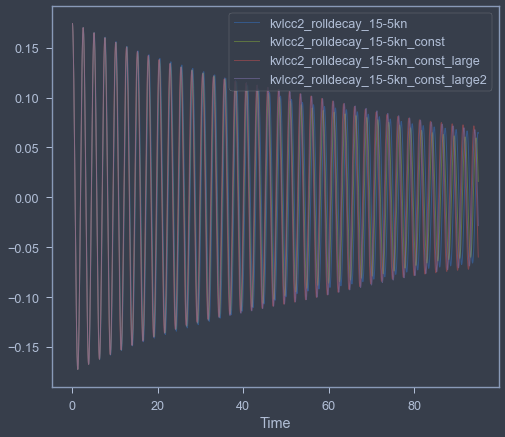

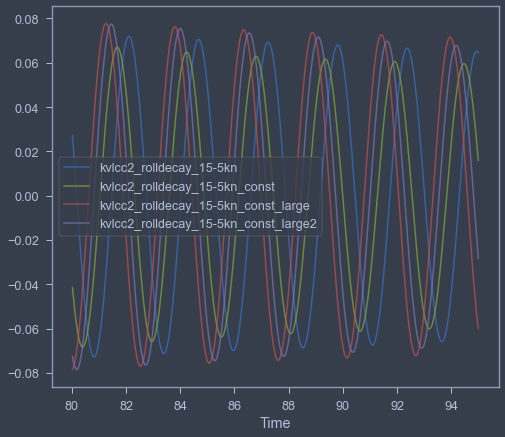

In [5]:
time_series = helpers.load_time_series(df_parameters=df_parameters)
time_series_raw = deepcopy(time_series)

for key,df in time_series.items():
    
    if df.mean().abs()['V1'] > 0.01:
        #X = preprocess.remove_acceleration_part(df=df, q=0.99, steady_ratio=0.01)
        
        phi1d_limit = 10**-2
        index0 = (df['phi1d'].abs() > phi1d_limit).argmax()
        X = df.iloc[index0:].copy()
        X.index-=X.index[0]  # Zeeroing time
        
        # Limit the amplitudes:
        mask = X.index < 95
        X = X.loc[mask].copy()
        
        time_series[key] = X

fig,ax=plt.subplots()
for key,df in time_series.items():
    df.plot(y='phi', ax=ax, label=key, alpha=0.5, lw=1)   
ax.legend()

fig,ax=plt.subplots()
for key,df in time_series.items():
    df.loc[80:].plot(y='phi', ax=ax, label=key, alpha=0.7, lw=1.5)   
ax.legend()

In [6]:
time_series.keys()

dict_keys(['kvlcc2_rolldecay_15-5kn', 'kvlcc2_rolldecay_15-5kn_const', 'kvlcc2_rolldecay_15-5kn_const_large', 'kvlcc2_rolldecay_15-5kn_const_large2'])

In [7]:
time_series['kvlcc2_rolldecay_15-5kn'].tail()

,Time_step,F1,F2,F3,F4,F5,F6,P1,P2,P3,P4,P5,P6,V1,V2,V3,V4,V5,V6,A1,A2,A3,A4,A5,A6,FBD1,FBD2,FBD3,FBD4,FBD5,FBD6,FIBD1,FIBD2,FIBD3,FIBD4,FIBD5,FIBD6,P1nom,P2nom,P3nom,P4nom,P5nom,P6nom,V1nom,V2nom,V3nom,V4nom,V5nom,V6nom,dP1,dP2,dP3,dP4,dP5,dP6,dV1,dV2,dV3,dV4,dV5,dV6,Wetted_surface_area,Iteration_time,Markers,Iteration_time/Markers,Time_factor,eta_at_CG,phi,dX,ts,phi1d,phi2d
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94.92,4945.0,-15.881307,-3.288129,9742.743837,-45.122846,1.504572,14.055763,93.820957,0.000775,-0.037392,3.729318,0.114187,0.002883,0.966869,0.001818,0.000732,0.422630,0.018536,0.001818,-0.000901,-0.005130,0.000622,-22.356213,0.062786,-0.019098,-14.774433,-3.169308,9743.623230,-44.889877,7.670980,14.292524,-2.367113,-3.168684,9743.623230,-44.889877,7.670980,14.292524,93.892879,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.071922,0.000773,-0.004992,3.729318,0.114187,0.002883,-0.000107,0.001818,0.000732,0.422630,0.018536,0.001818,6.013849,49.362207,10309.0,0.004788,2468.110364,0.0,0.065089,0.966869,4945.0,0.007376,-0.390190
94.94,4946.0,-15.818182,-4.042002,9742.350362,-45.255424,0.690808,14.200667,93.840294,0.000810,-0.037377,3.733290,0.114571,0.002917,0.966852,0.001714,0.000742,-0.025278,0.019898,0.001503,-0.000821,-0.005802,0.000226,-22.422100,0.028881,-0.010833,-15.023195,-3.252761,9743.651003,-44.936731,6.944356,14.259575,-2.616548,-3.252129,9743.651003,-44.936731,6.944356,14.259575,93.912218,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.071925,0.000809,-0.004977,3.733290,0.114571,0.002917,-0.000124,0.001714,0.000742,-0.025278,0.019898,0.001503,6.013722,49.669569,10299.0,0.004823,2483.478430,0.0,0.065158,0.966852,4946.0,-0.000441,-0.391339
94.96,4947.0,-15.748701,-3.979081,9741.158252,-45.238358,1.861446,14.469839,93.859631,0.000843,-0.037362,3.728303,0.114978,0.002944,0.966836,0.001597,0.000750,-0.473514,0.020669,0.001279,-0.000737,-0.005639,-0.000974,-22.413880,0.077661,0.001318,-14.768944,-3.610131,9742.020631,-44.839689,6.740328,14.366350,-2.363171,-3.609493,9742.020631,-44.839689,6.740328,14.366350,93.931558,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.071927,0.000842,-0.004962,3.728303,0.114978,0.002944,-0.000140,0.001597,0.000750,-0.473514,0.020669,0.001279,6.013474,48.705165,10330.0,0.004715,2435.258258,0.0,0.065071,0.966836,4947.0,-0.008264,-0.391196
94.98,4948.0,-15.647883,-4.205756,9741.542711,-45.008207,1.441696,14.034151,93.878967,0.000874,-0.037347,3.714355,0.115407,0.002968,0.966823,0.001486,0.000727,-0.921061,0.022520,0.001151,-0.000622,-0.005772,-0.000587,-22.299438,0.060172,-0.017917,-15.076889,-3.731217,9743.378023,-44.643740,4.587644,14.337610,-2.671749,-3.730574,9743.378023,-44.643740,4.587644,14.337610,93.950897,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.071930,0.000873,-0.004947,3.714355,0.115407,0.002968,-0.000153,0.001486,0.000727,-0.921061,0.022520,0.001151,6.013323,52.185728,10347.0,0.005044,2609.286389,0.0,0.064828,0.966823,4948.0,-0.016076,-0.389199
95.00,4949.0,-15.579850,-4.488526,9739.946166,-44.692737,1.314437,14.034273,93.898304,0.000903,-0.037333,3.691477,0.115870,0.002990,0.966811,0.001368,0.000710,-1.366158,0.023461,0.000941,-0.000542,-0.005955,-0.002194,-22.143175,0.054869,-0.016186,-14.700984,-4.019076,9742.460548,-44.349342,6.149325,13.888754,-2.296664,-4.018429,9742.460548,-44.349342,6.149325,13.888754,93.970237,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.071933,0.000901,-0.004933,3.691477,0.115870,0.002990,-0.000166,0.001368,0.000710,-1.366158,0.023461,0.000941,6.013065,56.896403,10382.0,0.005480,2844.820167,0.0,0.064428,0.966811,4949.0,-0.023844,-0.386471


In [8]:
time_series['kvlcc2_rolldecay_15-5kn_const_large2'].tail()

,Time_step,F1,F2,F3,F4,F5,F6,P1,P2,P3,P4,P5,P6,V1,V2,V3,V4,V5,V6,A1,A2,A3,A4,A5,A6,FBD1,FBD2,FBD3,FBD4,FBD5,FBD6,FIBD1,FIBD2,FIBD3,FIBD4,FIBD5,FIBD6,P1nom,P2nom,P3nom,P4nom,P5nom,P6nom,V1nom,V2nom,V3nom,V4nom,V5nom,V6nom,dP1,dP2,dP3,dP4,dP5,dP6,dV1,dV2,dV3,dV4,dV5,dV6,Wetted_surface_area,Iteration_time,Markers,Iteration_time/Markers,Time_factor,eta_at_CG,phi,dX,ts,phi1d,phi2d
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94.92,5931.0,-14.880780,-4.433179,9743.447484,11.502746,2.452058,-1.491375,110.983806,0.000167,-0.037373,-0.906502,0.116258,0.000681,0.967119,-0.002578,-0.001097,-9.242067,-0.013332,-0.006643,-0.000339,-0.002143,0.001330,5.699362,0.102077,-0.007442,-14.187626,-4.491289,9744.893578,11.497382,5.483168,-1.929355,-1.766550,-4.491141,9744.893578,11.497382,5.483168,-1.929355,111.054690,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.070884,0.000165,-0.004973,-0.906502,0.116258,0.000681,0.000143,-0.002578,-0.001097,-9.242067,-0.013332,-0.006643,6.017684,116.550070,74940.0,0.001555,5827.503517,0.0,-0.015821,0.967119,5931.0,-0.161304,0.099473
94.94,5932.0,-14.919244,-4.164374,9743.813135,13.740665,2.591803,-2.108213,111.003149,0.000115,-0.037395,-1.090130,0.116013,0.000547,0.967112,-0.002617,-0.001065,-9.116968,-0.011166,-0.006794,-0.000371,-0.001827,0.001698,6.808068,0.107900,-0.003163,-14.023798,-4.051062,9747.453878,13.547644,6.790897,-2.869407,-1.602039,-4.050943,9747.453878,13.547644,6.790897,-2.869407,111.074030,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.070881,0.000113,-0.004995,-1.090130,0.116013,0.000547,0.000136,-0.002617,-0.001065,-9.116968,-0.011166,-0.006794,6.018096,115.211832,75007.0,0.001536,5760.591610,0.0,-0.019026,0.967112,5932.0,-0.159121,0.118823
94.96,5933.0,-14.983354,-3.737627,9744.791354,15.887064,3.175332,-2.648382,111.022491,0.000062,-0.037416,-1.271036,0.115812,0.000410,0.967104,-0.002650,-0.001031,-8.970015,-0.008852,-0.006863,-0.000429,-0.001356,0.002683,7.871401,0.132216,0.002518,-14.184849,-3.772631,9747.178609,15.726304,6.553056,-3.352058,-1.761729,-3.772542,9747.178609,15.726304,6.553056,-3.352058,111.093369,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.070879,0.000061,-0.005016,-1.271036,0.115812,0.000410,0.000128,-0.002650,-0.001031,-8.970015,-0.008852,-0.006863,6.018844,115.516184,74942.0,0.001541,5775.809187,0.0,-0.022184,0.967104,5933.0,-0.156556,0.137382
94.98,5934.0,-15.084532,-3.214719,9744.283788,17.976704,2.818566,-3.537784,111.041833,0.000009,-0.037436,-1.448790,0.115662,0.000273,0.967094,-0.002674,-0.000973,-8.801907,-0.006104,-0.006829,-0.000523,-0.000797,0.002172,8.906989,0.117353,-0.009157,-14.425191,-3.816691,9746.652224,17.845270,5.467682,-3.758266,-2.000394,-3.816632,9746.652224,17.845270,5.467682,-3.758266,111.112709,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.070876,0.000007,-0.005036,-1.448790,0.115662,0.000273,0.000118,-0.002674,-0.000973,-8.801907,-0.006104,-0.006829,6.019764,110.512993,75070.0,0.001472,5525.649656,0.0,-0.025286,0.967094,5934.0,-0.153622,0.155456
95.00,5935.0,-15.084686,-3.264341,9745.102407,20.268098,3.309977,-3.970820,111.061174,-0.000045,-0.037455,-1.622971,0.115566,0.000136,0.967084,-0.002689,-0.000930,-8.612788,-0.003601,-0.006876,-0.000514,-0.000821,0.002996,10.042075,0.137832,0.000378,-14.512514,-3.539486,9748.557526,19.897442,5.466750,-4.518337,-2.086381,-3.539457,9748.557526,19.897442,5.466750,-4.518337,111.132049,0.000001,-0.0324,0.0,0.0,0.0,0.966976,0.0,0.0,0.0,0.0,0.0,-0.070874,-0.000046,-0.005055,-1.622971,0.115566,0.000136,0.000108,-0.002689,-0.000930,-8.612788,-0.003601,-0.006876,6.020528,117.300392,75097.0,0.001562,5865.019583,0.0,-0.028326,0.967084,5935.0,-0.150322,0.175267


In [9]:
def join_time_series(time_series:dict, key:str):
    
    df_ = pd.DataFrame()
    
    for run_name,df in time_series.items():
    
        if len(df_)==0:
            df_[run_name] = df[key].copy()
        else:
            df_[run_name] = df[key].values  # Assuming same time...
        
    return df_

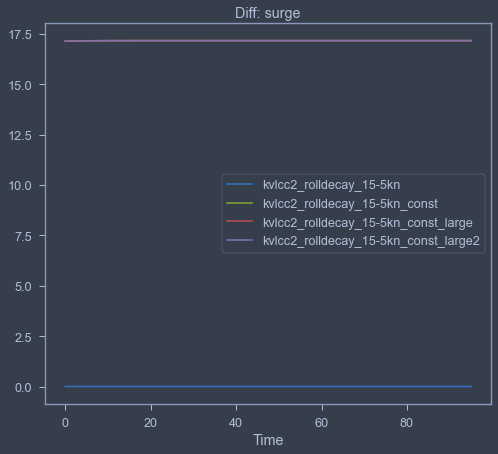

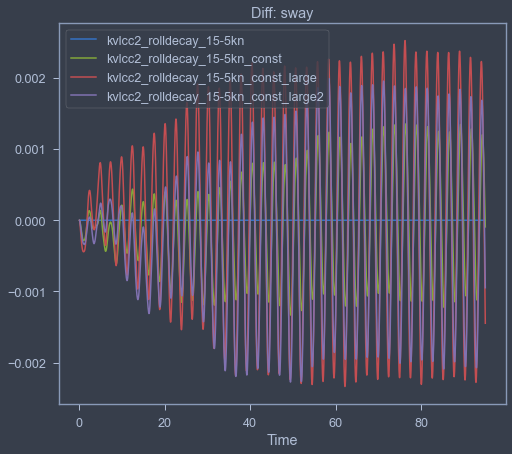

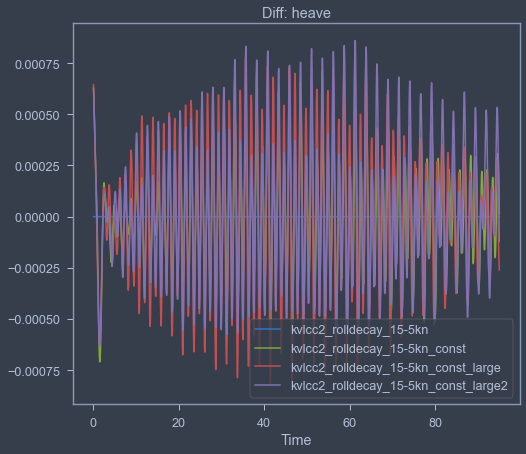

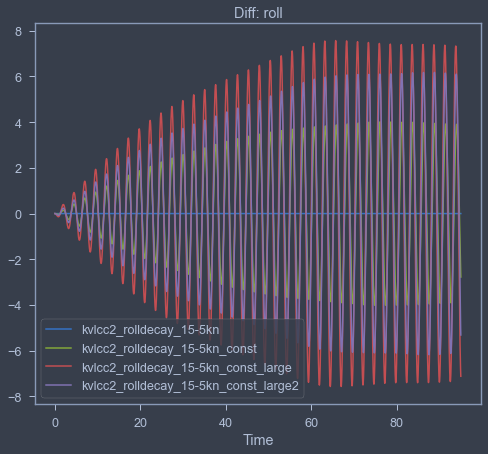

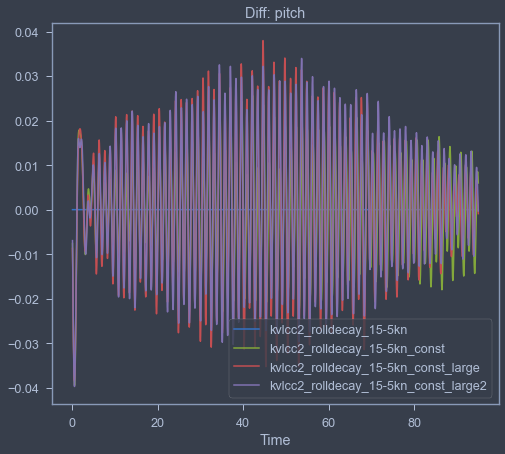

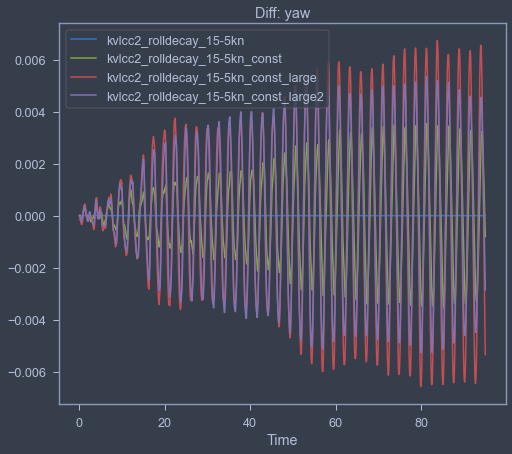

In [10]:
titles = {
    1 : 'surge',
    2 : 'sway',
    3 : 'heave',
    4 : 'roll',
    5 : 'pitch',
    6 : 'yaw',
}

for dof in range(1,7):
    dof_key = 'P%i' % dof
    fig,ax=plt.subplots()
    ax.set_title('Diff: %s' % titles[dof])
    
    df_ = join_time_series(time_series=time_series, key=dof_key)
    df_error = df_.sub(df_['kvlcc2_rolldecay_15-5kn'], axis=0)
    
    df_error.plot(ax=ax)
    

In [11]:
df_ = join_time_series(time_series=time_series, key='phi')

In [12]:
df_.head()

,kvlcc2_rolldecay_15-5kn,kvlcc2_rolldecay_15-5kn_const,kvlcc2_rolldecay_15-5kn_const_large,kvlcc2_rolldecay_15-5kn_const_large2
Time,,,,
0.00,0.174094,0.174093,0.174088,0.174090
0.02,0.173195,0.173193,0.173175,0.173185
0.04,0.171908,0.171904,0.171868,0.171887
0.06,0.170190,0.170183,0.170123,0.170154
0.08,0.168053,0.168040,0.167953,0.167996


<AxesSubplot:xlabel='Time'>

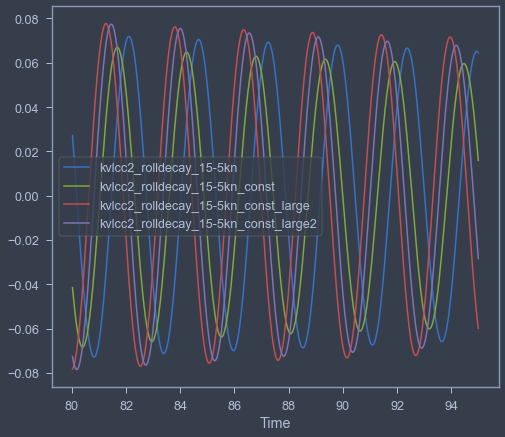

In [13]:
df_[80:].plot()

<AxesSubplot:xlabel='Time'>

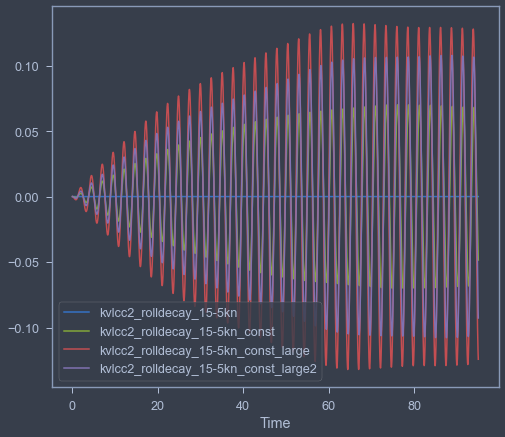

In [14]:
df_error = df_.sub(df_['kvlcc2_rolldecay_15-5kn'], axis=0)
df_error.plot()

<AxesSubplot:xlabel='Time'>

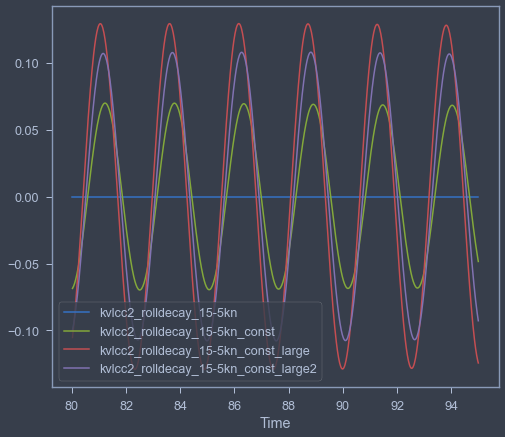

In [15]:
df_error[80:].plot()

<AxesSubplot:xlabel='Time'>

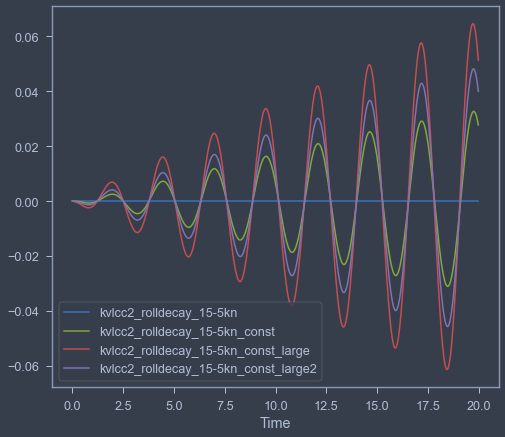

In [16]:
df_error[0:20].plot()

In [17]:
motion_models = {}

for motions_file_path,X in time_series.items():
        
    parameters = df_parameters.loc[motions_file_path]
        
    pre_model = EstimatorQuadraticB(fit_method='derivation')
    pre_model.fit(X=X)
    model = EstimatorQuadraticB(fit_method='integration', p0=pre_model.parameters)
        
    try:
        model.fit(X=X)
    except scipy.linalg.LinAlgError:
        model.fit(X=X)  # Retry
    
    if pre_model.score() > model.score():
        model = pre_model
    
    motion_models[motions_file_path] = model
    

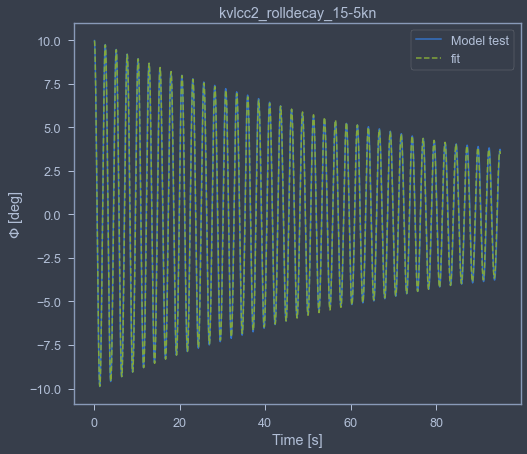

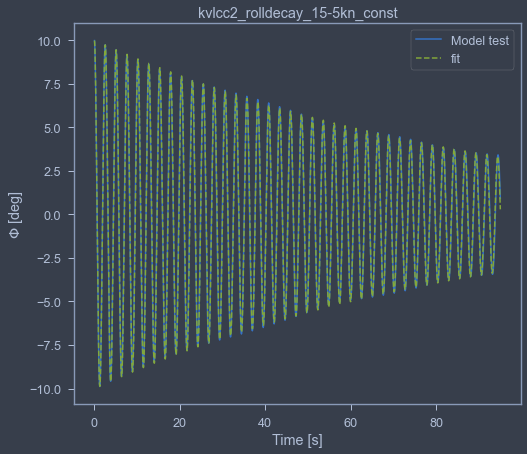

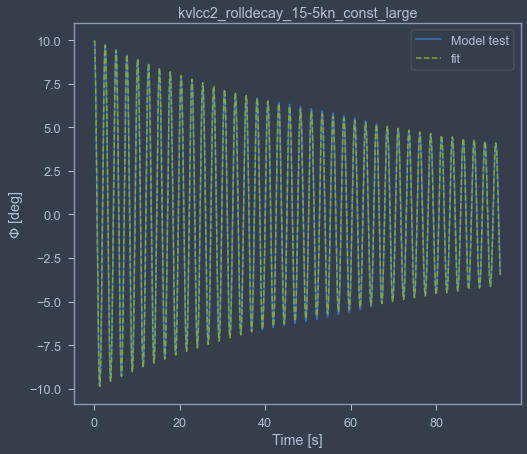

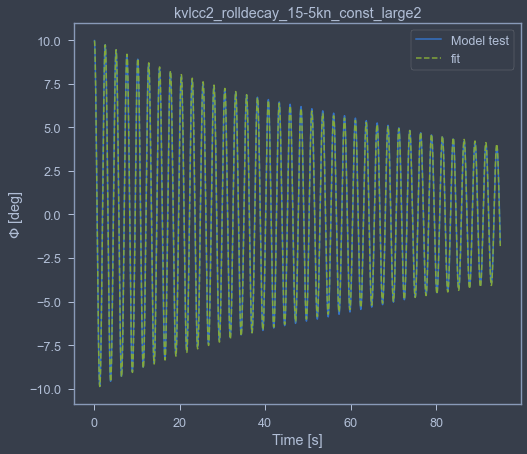

In [18]:
for motions_file_path,model in motion_models.items():
    
    fig,ax=plt.subplots()
    model.plot_fit(ax=ax)
    ax.set_title(motions_file_path)
    

<AxesSubplot:xlabel='Time'>

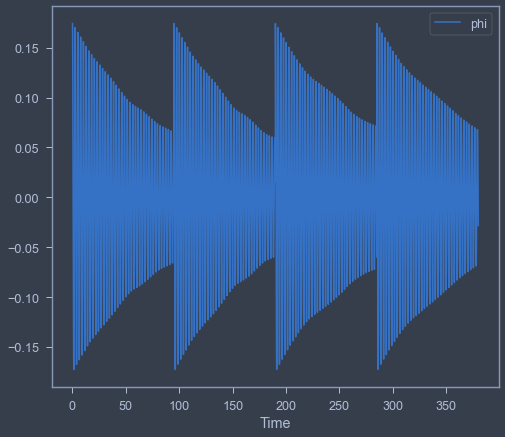

In [19]:
X = pd.DataFrame()
for run_name, df in time_series.items():
    if len(X)==0:
        X = df
    else:
        df_ = df.copy()
        dt = df_.index[1] - df_.index[0]
        df_.index+=dt
        df_.index+=X.index[-1]
        X = X.append(df_)
      
X.plot(y='phi')

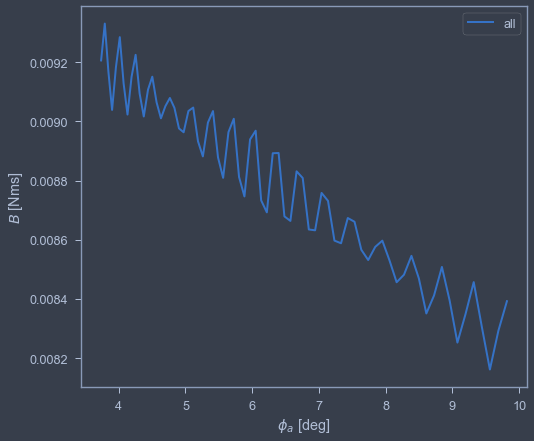

In [20]:
model = EstimatorQuadraticB(fit_method='derivation')
model.fit(X=X)
model.X = time_series['kvlcc2_rolldecay_15-5kn']

motion_models['all'] = model

fig,ax=plt.subplots()
model.plot_damping(ax=ax, label='all', include_model_test=False)

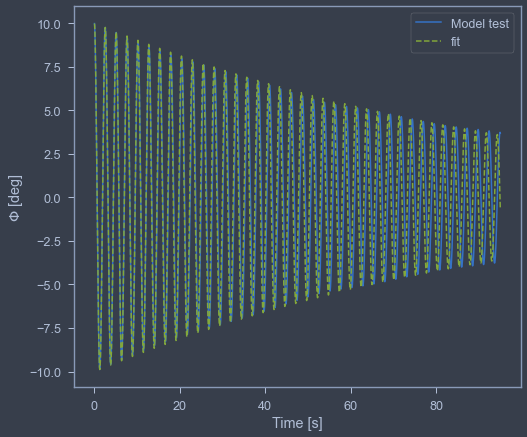

In [21]:
model.plot_fit()

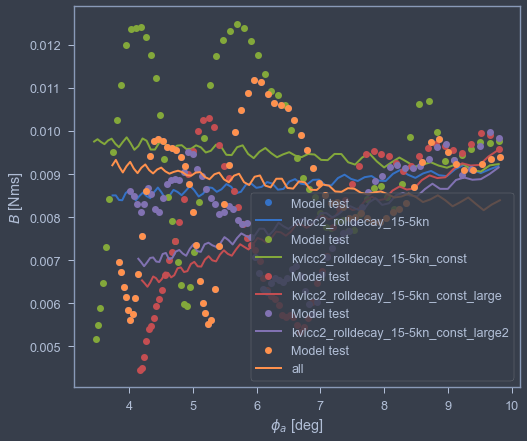

In [22]:
fig,ax=plt.subplots()

for model_name, model in motion_models.items():
    model.plot_damping(ax=ax, label=model_name, include_model_test=True)

<a id='motions_sensitivity'></a>

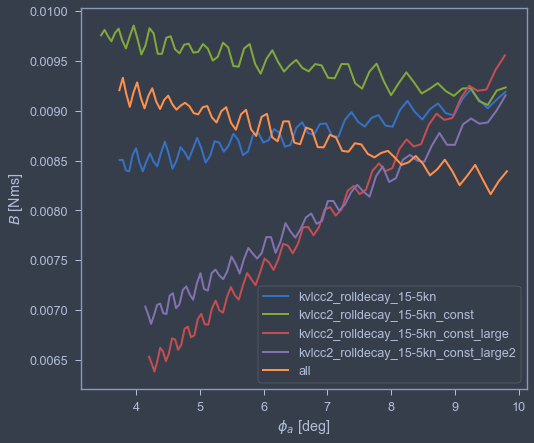

In [23]:
fig,ax=plt.subplots()

for model_name, model in motion_models.items():
    model.plot_damping(ax=ax, label=model_name, include_model_test=False)
    

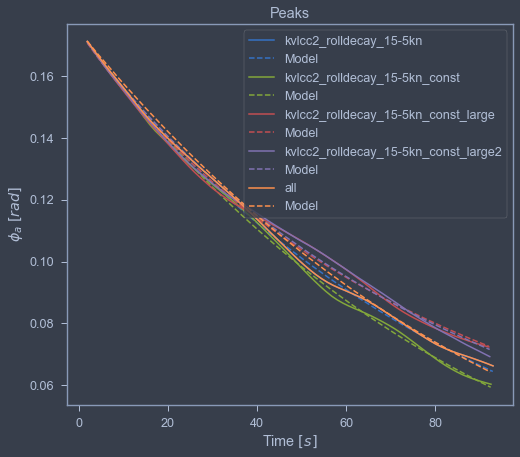

In [24]:
fig,ax=plt.subplots()

for model_name, model in motion_models.items():
    model.calculate_amplitudes_and_damping()
    model.plot_peaks(ax=ax, label=model_name)
    
    color = ax.get_lines()[-1].get_color()
    model.X_pred_amplitudes.plot(y='phi', style='--', color=color, label='Model', ax=ax)
    
    
ax.set_ylabel(r'$\phi_a$ $[rad]$')
ax.set_xlabel(r'Time $[s]$')
ax.legend()

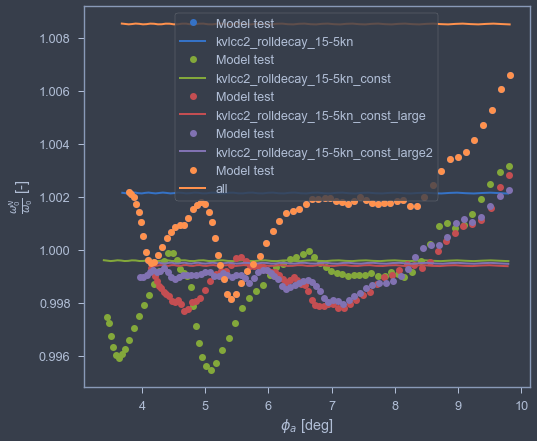

In [25]:
fig,ax=plt.subplots()

for model_name, model in motion_models.items():
    model.plot_omega0(ax=ax, label=model_name, include_model_test=True)